## Market risk management tools- VaR estimation and backtest framework
#### This notebook is aim to provide investors and financial risk managers with a plausible framework to conduct VaR analysis and validate the model through backtesting.
##### ***The codes and contents was created by Wei-Yu Chen. All copyright reserved***

In [20]:
import pandas as pd
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 15)
import sqlalchemy 
import tejapi
import numpy as np
from datetime import date,timedelta
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
import pandas_datareader.data as web
import datetime 
from arch import arch_model
import math

### 1. Create a pseudo portfolio for VaR calculation. Price data were retreat from Yahoo Finance.

In [21]:
start = datetime .datetime(2005, 1, 1)
end = datetime .datetime(2022, 1, 1)
sp500 = web.DataReader('^GSPC', 'yahoo', start=start, end=end)
N225 = web.DataReader('^N225', 'yahoo', start=start, end=end)
gold = web.DataReader('GC=F', 'yahoo', start=start, end=end)
shanghai_index = web.DataReader('000001.SS', 'yahoo', start=start, end=end)
vanguardBond = web.DataReader('VBMFX', 'yahoo', start=start, end=end)
nasdaqIndex = web.DataReader('^IXIC', 'yahoo', start=start, end=end)

In [22]:
n225_pl = N225['Adj Close'].to_frame('Nikkei 225 Index').dropna()
gold_pl = gold['Adj Close'].to_frame('Gold').dropna()
shi_pl = shanghai_index['Adj Close'].to_frame('Shanghai Composite Index').dropna()
sp500_pl = sp500['Adj Close'].to_frame('S&P500 Index').dropna()
bond_pl = vanguardBond['Adj Close'].to_frame('Vanguard Bond Index Fund').dropna()
comm_pl = nasdaqIndex['Adj Close'].to_frame('Nasdaq Index').dropna()
portfolio_prices = sp500_pl.merge(n225_pl,right_index=True, left_index = True).merge(gold_pl,right_index=True, left_index = True).merge(shi_pl,right_index=True, left_index = True)
portfolio_prices = portfolio_prices.merge(bond_pl,right_index=True, left_index = True).merge(comm_pl,right_index=True, left_index = True)
summary_PnL = portfolio_prices.pct_change().dropna()
portfolio_prices.head(3).style.format('{:,.4f}')

,S&P500 Index,Nikkei 225 Index,Gold,Shanghai Composite Index,Vanguard Bond Index Fund,Nasdaq Index
Date,,,,,,
2005-01-04 00:00:00,"1,188.0500","11,517.7500",428.5000,"1,242.7740",6.0919,"2,107.8601"
2005-01-05 00:00:00,"1,183.7400","11,437.5195",426.6000,"1,251.9370",6.0919,"2,091.2400"
2005-01-06 00:00:00,"1,187.8900","11,492.2598",421.0000,"1,239.4301",6.0978,"2,090.0000"


In [23]:
summary_PnL = summary_PnL.reset_index().drop_duplicates(subset='Date', keep='last').set_index('Date').sort_index()
weights = np.array([.30,.30,.05,.10,.20,.05]) 

### 2. Create a value-at-risk class and define methods within.

In [580]:
class ValueAtRisk:
    
    '''
        1. The the first code block calculate basic peformance indicators of each asset in the portfolio.
            Please fill in a dataframe of assets daily PnL and the the following fuctions will calculate performance for the given sample perriod.
    '''
    
    def __init__(self, daily_return, weights):
        self.daily_return = daily_return
        self.weights = weights
        self.cov_matrix = daily_return.cov()
        self.overview = self.portfolio_overview(daily_return, weights)

    def performance_analysis(self, daily_return, asset_name, weight, riskfreerate = 0.03, days = 250, asset_value_beg = 1000000):        
        length = len(daily_return)
        rbar   = daily_return.mean()
        rbar_percent = rbar*100
        sigma      = daily_return.std()
        s_percent = sigma*100
        sharperatio   = np.sqrt(days)*(rbar - riskfreerate/days)/sigma
        cumuret = ((daily_return + 1)).cumprod()-1
        cumuret_per = cumuret*100
        nav = cumuret+1
        asset_value_end = round(asset_value_beg * nav[-1],2)
        waterlevel = nav.cummax()
        drawdown = (waterlevel-nav)/waterlevel
        duration = np.zeros_like(drawdown)
        for k in range(length - 1):
            if drawdown[k + 1] > 0:
                duration[k + 1] = duration[k] + 1
            else:
                duration[k + 1] = 0
        mdd = drawdown.max()*100
        mddd = duration.max()
        perf = pd.DataFrame()
        feature_idx = ['Beginning balance','Ending balance','Period return','Mean return (daily)','Standard deviation (daily)','Sharpe ratio (annualized)',
                       'Maximum drawdown','Maximum drawdown duration']
        pef_summary = [f"{asset_value_beg:,}" ,f"{asset_value_end:,}" ,'%0.2f'%cumuret_per[-1:]+'%','%0.4f'%rbar_percent+'%','%0.4f'%s_percent+'%','%0.4f'%sharperatio,
                       '%0.2f'%mdd+'%', '%d'%mddd+' days']
        perf['Asset/Performance'] = feature_idx
        perf[asset_name] = pef_summary
        return perf
    
    def portfolio_overview(self,df,weights,period=250):
        df = df[-period:]
        df['Total Portfolio'] = np.average(df, 1, weights)
        weights = np.append(weights,1) #add weight element for total portfolio 
        cols = df.columns 
        feature_idx = ['Beginning balance','Ending balance','Period return','Mean return (daily)','Standard deviation (daily)','Sharpe ratio (annualized)',
                       'Maximum drawdown','Maximum drawdown duration']
        perf_table = pd.DataFrame()
        perf_table['Asset/Performance'] = feature_idx
        for col, weight in zip(cols,weights):
            perf = self.performance_analysis(df[col],col,weight)
            perf_table = perf_table.merge(perf,on='Asset/Performance')
            perf_table = perf_table.set_index('Asset/Performance')
        return perf_table.T

        
        '''
        2. This code block includes functions that apply different approaches of calculating VaR.
            Please input a dataframe of assets daily PnL and the the following fuctions will calculate VaR for the given sample perriod.
        '''
        
    def parametric(self, daily_return, weights):
        cov_matrix = daily_return.cov()
        date = daily_return.index.max()
        z1 = norm.ppf(5/100)
        z2 = norm.ppf(2.5/100)
        z3 = norm.ppf(1/100)
        daily_mean = np.average(daily_return, 1, weights)
        port_mean =daily_mean.mean()
        port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
        var_95 = port_mean + z1 * port_stdev 
        var_975 = port_mean + z2 * port_stdev 
        var_99 = port_mean + z3 * port_stdev 
        cvar_975 = np.mean(daily_mean[daily_mean <= var_975])
        var_dict = {'VaR(95%)':var_95,'VaR(97.5%)':var_975,'VaR(99%)':var_99,'Expected Shortfall(97.5%)':cvar_975}
        df = pd.DataFrame(var_dict,index=[date])
        return df
    
    def historic(self,daily_return,weights):
        cov_matrix = daily_return.cov()
        date = daily_return.index.max()
        daily_return = np.average(daily_return, 1, weights)
        var_95 = np.percentile(daily_return,5)
        var_975 = np.percentile(daily_return,2.5)
        var_99 = np.percentile(daily_return,1)
        cvar_975 = np.mean(daily_return[daily_return <= var_975])
        var_dict = {'VaR(95%)':var_95,'VaR(97.5%)':var_975,'VaR(99%)':var_99,'Expected Shortfall(97.5%)':cvar_975}
        df = pd.DataFrame(var_dict,index=[date])
        return df
    
    def monte_carlo(self, daily_return,weights):
        date = daily_return.index.max()
        mu = np.mean(np.average(daily_return, 1, weights))
        vol = np.std(np.average(daily_return, 1, weights))
        T = 250
        simulated_PnL = []
        for i in range(T):
            rand_rets = np.random.normal(mu, vol, 1000)
            simulated_PnL.append(rand_rets)
        var_95 = np.percentile(simulated_PnL,5)
        var_975 = np.percentile(simulated_PnL,2.5)
        var_99 = np.percentile(simulated_PnL,1)
        PnL_frame = pd.DataFrame(simulated_PnL)
        extrem_loss = PnL_frame[PnL_frame <= var_975]
        cvar_975 = np.nanmean(extrem_loss)
        var_dict = {'VaR(95%)':var_95,'VaR(97.5%)':var_975,'VaR(99%)':var_99,'Expected Shortfall(97.5%)':cvar_975}
        df = pd.DataFrame(var_dict,index=[date])
        return df
    
    def para_garch(self,daily_return,weights):
        date = daily_return.index.max()
        weighted_avg = pd.DataFrame()
        weighted_avg['weighted_avg'] = np.average(daily_return, 1, weights) * 100
        am = arch_model(weighted_avg, vol='Garch', p=1, o=0 ,q=1, dist='skewt')
        res = am.fit(disp='off')
        forecasts = res.forecast()
        cond_mean = forecasts.mean
        cond_var = forecasts.variance
        q = am.distribution.ppf([0.05, 0.01, 0.025], res.params[-2:])
        value_at_risk = cond_mean.values + np.sqrt(cond_var).values * q[None, :]
        var_95 = value_at_risk[[-1,]][0][0]
        var_99 = value_at_risk[[-1,]][0][1]
        var_975 = value_at_risk[[-1,]][0][2]
        cvar_975 = np.mean(weighted_avg[weighted_avg['weighted_avg'] <= var_975])
        if math.isnan(cvar_975):
            cvar_975 = [var_99]
        var_dict = {'VaR(95%)':var_95,'VaR(97.5%)':var_975,'VaR(99%)':var_99,'Expected Shortfall(97.5%)':cvar_975[0]}
        df = pd.DataFrame(var_dict,index=[date])
        df = df / 100
        return df[-1:]
    
    def VaR_summary(self, df, weights, amount):
        summary = pd.DataFrame()
        summary = summary.append(self.parametric(df, weights)).append(self.historic(df, weights)).append(self.monte_carlo(df, weights)).append(self.para_garch(df, weights))
        idx = ['Parametric','Historical','Monte Carlo','GARCH']
        summary.index = idx
        summary.index.name = time.strftime("%Y-%m-%d")
        return summary * amount

        '''
        3. This code block defines function to generate data for backtest.
        '''
        
    def backtest_data(self, daily_return, weights, method, window_days=250):
        start_time = time.time()
        method_map = {'Parametric':self.parametric,'Historical':self.historic,'MonteCarlo':self.monte_carlo,'Parametric-GARCH':self.para_garch}
        method_applied = method_map[method]        
        weighted_daily_PnL = pd.DataFrame(np.average(daily_return, 1, weights),index = daily_return.index, columns = ['Daily PnL'])
        daily_VaR_table = pd.DataFrame()
        for i in range(len(daily_return)-window_days):
            daily_PL = daily_return[i:i+window_days]
            date = daily_PL.index.max()
            daily_VaR = method_applied(daily_PL,weights)
            daily_VaR_table = daily_VaR_table.append(daily_VaR)

        daily_VaR_table.index = daily_VaR_table.index + pd.DateOffset(1)
        df = pd.merge_asof(weighted_daily_PnL,daily_VaR_table, right_index = True, left_index = True)
        df['VaR(95%) exception'] = np.where((df['VaR(99%)'] < df['Daily PnL']) & (df['Daily PnL'] < df['VaR(95%)']),'True','False')
        df['VaR(99%) exception'] = np.where(df['Daily PnL'] < df['VaR(99%)'],'True','False')  
        df = df.dropna()
        print(method+':',"--- %s seconds ---" % (time.time() - start_time))
        return df   

    
        '''
        4. The final code block defines functions to visualize VaR and expectd shortfall backtest. 
        '''
    
    def backtest_plot(self, VaR_table, model_name, begin_date='2005-01-01', end_date='2021-06-01'):
        VaR_table = VaR_table[begin_date:end_date]
        observations = len(VaR_table)
        fig,ax = plt.subplots(1,1,figsize=(18,10))
        normal_PnL = VaR_table[(VaR_table['VaR(95%) exception']=='False') & (VaR_table['VaR(99%) exception']=='False')]['Daily PnL']
        ax.plot(VaR_table['Daily PnL'], color = '#1ba1e2')
        ax.plot(VaR_table['VaR(95%)'], color = '#fa6800', alpha = 0.7)
        ax.plot(VaR_table['VaR(99%)'], color = '#e51400', alpha = 0.7)
        exceed_95 = VaR_table[VaR_table['VaR(95%) exception']=='True']['Daily PnL']
        exceed_99 = VaR_table[VaR_table['VaR(99%) exception']=='True']['Daily PnL']
        count_95 = (exceed_95.count() + exceed_99.count()) / observations
        count_99 = exceed_99.count() / observations

        r = VaR_table.index
        
        description = 'Excepctions Analysis: '+\
               '\n  -Number of observations: ' + str(observations) + ' days'+ \
               '\n  -VaR(95%) exceptions: ' + str(exceed_95.count() + exceed_99.count())+' times ('+str(round(count_95*100,2))+'%)'+ \
               '\n  -VaR(99%) exceptions: ' + str(exceed_99.count())+' times ('+str(round(count_99*100,2))+'%)' 
        
        ax.text(r[-(round(observations/4))], VaR_table['Daily PnL'].max()*.825, description,size=12 , bbox=dict(boxstyle='square', facecolor='white', alpha=0.3))

        ax.scatter(exceed_95.index,exceed_95,marker='s',  facecolors='none', edgecolors='#BB00BB', s = 120) #'#BB00BB'
        ax.scatter(exceed_99.index,exceed_99,marker='x',  facecolors='#a20025', s = 120) ##a20025
        ax.spines['bottom'].set_color('#b0abab')
        ax.spines['top'].set_color('#b0abab')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(linestyle='--', alpha=0.5)
        ax.legend(['Daily PnL','VaR(95%)','VaR(99%)','VaR(95%) exceptions','VaR(99%) exceptions'],loc='upper left',prop={'size': 12})
        ax.set_title(model_name + ' VaR Backtest', fontsize=16, fontweight=1)
        plt.show()
        
    def ES_plot(self, VaR_table, model, begin_date='2005-01-01', end_date='2021-06-01'):
        VaR_table = VaR_table[begin_date:end_date]
        observations = len(VaR_table)
        VaR_exception = VaR_table[['Daily PnL','VaR(97.5%)','Expected Shortfall(97.5%)']][VaR_table['Daily PnL'] <= VaR_table['VaR(97.5%)']]
        VaR_exception['deviation'] = VaR_exception['Daily PnL'] - VaR_exception['Expected Shortfall(97.5%)']
        mean, max_, min_, std = VaR_exception['deviation'].mean() , VaR_exception['deviation'].max() ,VaR_exception['deviation'].min(),VaR_exception['deviation'].std()
        mean, max_, min_, std = round(mean*100,2), round(max_*100,2), round(min_*100,2) , round(std*100,2) 
        ES_exception = VaR_table[['Daily PnL','Expected Shortfall(97.5%)']][VaR_table['Daily PnL'] <= VaR_table['Expected Shortfall(97.5%)']]
        VaR_except = len(VaR_exception)
        VaR_rate = round(VaR_except/observations*100,2)
        ES_except = len(ES_exception)
        ES_rate = round(ES_except/observations*100,2)
        x = np.arange(VaR_except)  # the label locations
        width = 0.35  # the width of the bars
        fig,ax = plt.subplots(1,1,figsize=(18,8))
        rects1 = ax.bar(x , VaR_exception['Daily PnL'], width, label='Actual Loss',alpha=1, color = '#1ba1e2')
        rects2 = ax.plot(x, VaR_exception['Expected Shortfall(97.5%)'],  label='Expected Shortfall(97.5%)', color = 'deeppink', alpha = 0.7)
        description = 'Exceptions Analysis: '+\
                       '\n  -Number of observations: ' + str(observations) + ' days'+ \
                       '\n  -VaR(97.5%) exceptions: ' + str(VaR_except)+' times ('+str(VaR_rate)+'%)'+ \
                       '\n  -ES(97.5%) exceptions: ' + str(ES_except)+' times ('+str(ES_rate)+'%)' + \
                      '\n\nDeviation Analysis (Actual - Expected): ' + \
                         '\n  -mean: ' + str(mean)+'% '+\
                         '\n  -std: ' + str(std)+'% '+\
                         '\n  -95% CI: ' + str(round(mean-1.96*std,2))+'% ~ '+ str(round(mean+1.96*std,2)) +'%'+\
                         '\n  -max: ' + str(max_)+'% (Worst underestimation)'+\
                         '\n  -min: ' + str(min_)+'% (Worst overestimation)'
        ax.text((VaR_except*2.75//4), VaR_exception['Daily PnL'].min(), description, size=12, bbox=dict(boxstyle='square', facecolor='white', alpha=0.3))
        ax.set_ylabel('PnL%')
        ax.set_title(model+' Expected Shortfall(97.5%) Exceptions Review', fontsize=16, fontweight=1)
        ax.set_xticks(x)
        ax.set_xticklabels(VaR_exception.index.strftime("%Y-%m-%d"),rotation='vertical')
        ax.legend(loc=3,prop={'size': 12})
        ax.spines['bottom'].set_color('#b0abab')
        ax.spines['top'].set_color('#b0abab')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(linestyle='--', alpha=0.5)
        plt.show()

### 3. Initiate a VaR object by plugging in an assets PnL table and portfolio weights.

In [581]:
VaR = ValueAtRisk(summary_PnL,weights)

####    a. The overview attribute is used to demontrate an overview of assets performance within a given period. (The preset is the last 250 days)

In [594]:
VaR.overview

Asset/Performance,Beginning balance,Ending balance,Period return,Mean return (daily),Standard deviation (daily),Sharpe ratio (annualized),Maximum drawdown,Maximum drawdown duration
S&P500 Index,"1,000,000","1,222,365.35",22.24%,0.1057%,2.2423%,0.6605,28.52%,57 days
Nikkei 225 Index,"1,000,000","1,271,266.91",27.13%,0.1104%,1.7014%,0.9144,26.77%,61 days
Gold,"1,000,000","1,058,068.83",5.81%,0.0335%,1.4808%,0.2298,18.22%,146 days
Shanghai Composite Index,"1,000,000","1,144,739.75",14.47%,0.0622%,1.2801%,0.6201,13.40%,73 days
Vanguard Bond Index Fund,"1,000,000","1,011,334.8",1.13%,0.0051%,0.3401%,-0.3216,6.53%,146 days
Nasdaq Index,"1,000,000","1,429,406.51",42.94%,0.1704%,2.3348%,1.0730,23.92%,48 days
Total Portfolio,"1,000,000","1,208,435.77",20.84%,0.0823%,1.1406%,0.9740,19.14%,58 days


####    b. The VaR summary table demonstrates VaR under different methods and confidence interval.

In [595]:
# The third variable in the function is the dollar amount of the total portfolio.
VaR.VaR_summary(summary_PnL,weights, 1000000).style.format('{:,.0f}')

,VaR(95%),VaR(97.5%),VaR(99%),Expected Shortfall(97.5%)
2021-04-11,,,,
Parametric,"-12,564","-15,043","-17,925","-25,091"
Historical,"-10,974","-14,924","-23,244","-24,978"
Monte Carlo,"-12,566","-15,105","-17,960","-18,084"
GARCH,"-9,802","-12,681","-16,724","-21,625"


####    c. The backtest_data function generate backtested VaR on a rolling basis. (The preset is 250 days)

In [94]:
#Backtest of 12 years data
para_var = VaR.backtest_data(summary_PnL, weights, 'Parametric')
hist_var = VaR.backtest_data(summary_PnL, weights, 'Historical')
mcvar = VaR.backtest_data(summary_PnL, weights, 'MonteCarlo')
garch_var = VaR.backtest_data(summary_PnL, weights, 'Parametric-GARCH')

Parametric: --- 14.080958127975464 seconds ---
Historical: --- 17.973863124847412 seconds ---
MonteCarlo: --- 631.1320626735687 seconds ---
GARCH: --- 290.8229024410248 seconds ---


####    d. The backtest_plot function visualizes the backtested VaRs with identification of exceptions.

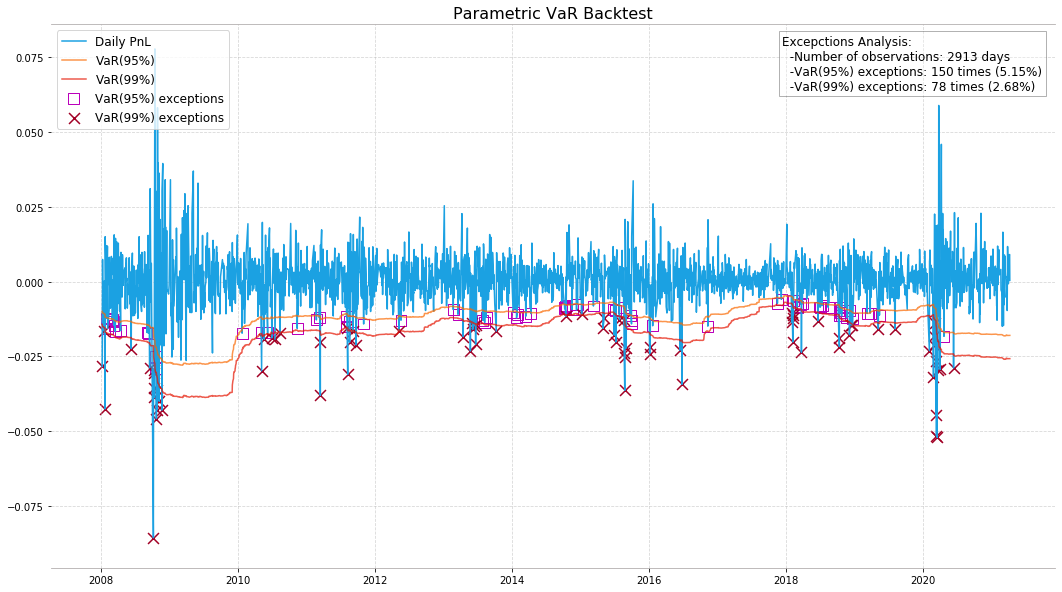

In [596]:
VaR.backtest_plot(para_var, 'Parametric', begin_date='2008-01-01', end_date='2021-06-01')

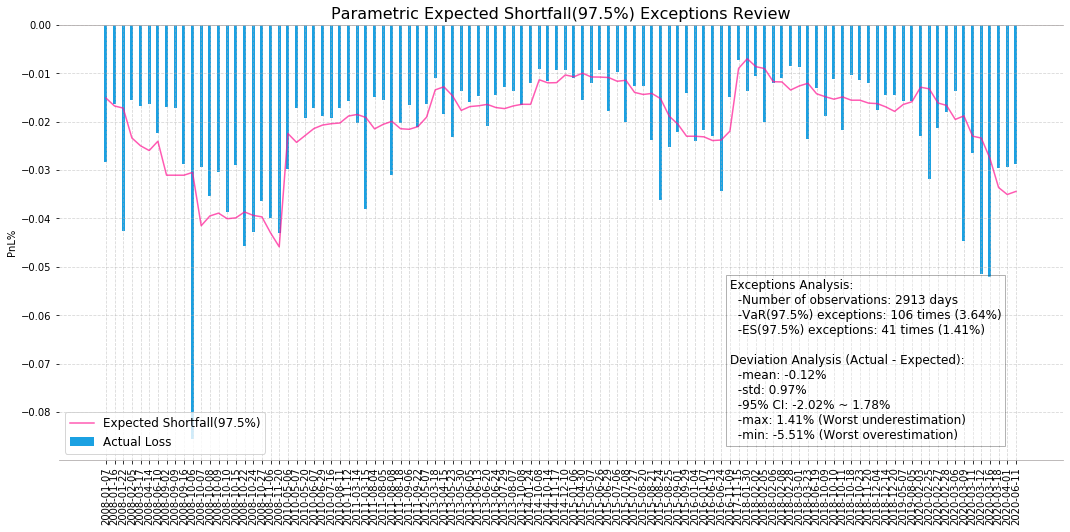

In [597]:
VaR.ES_plot(para_var,'Parametric',begin_date='2008-01-01')

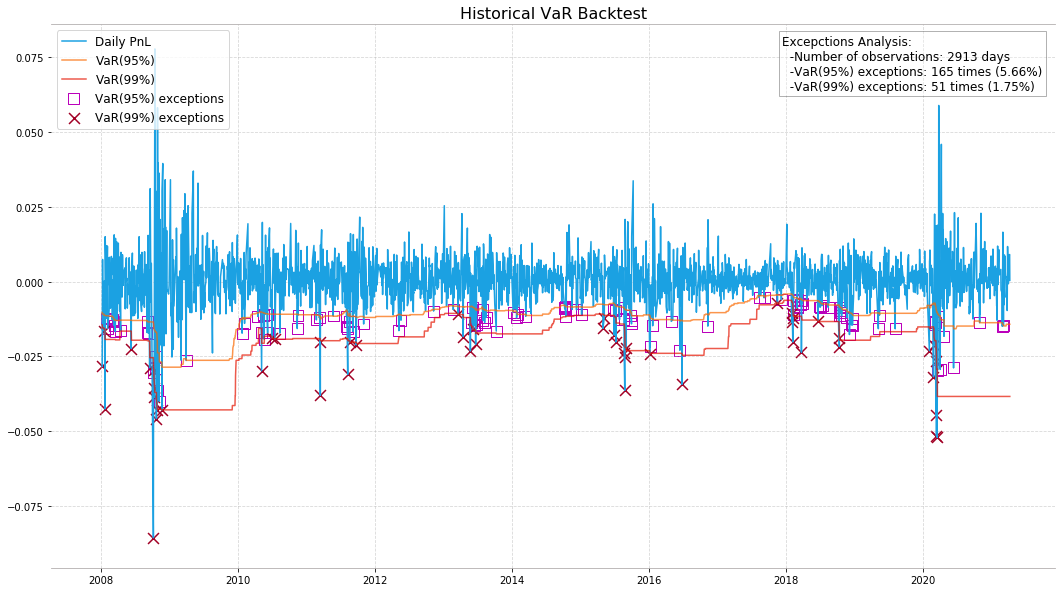

In [598]:
VaR.backtest_plot(hist_var, 'Historical', begin_date='2008-01-01', end_date='2021-06-01')

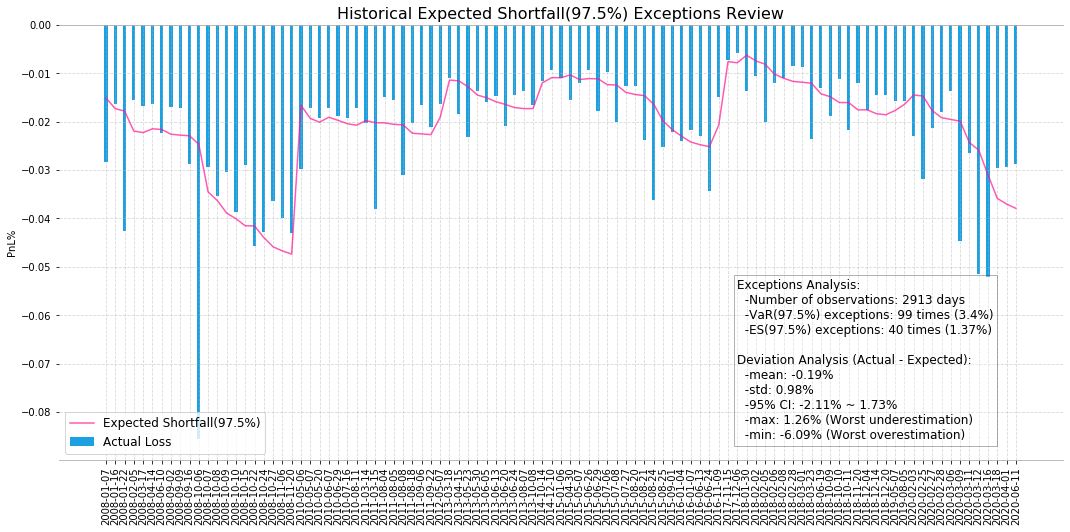

In [599]:
VaR.ES_plot(hist_var,'Historical',begin_date='2008-01-01')

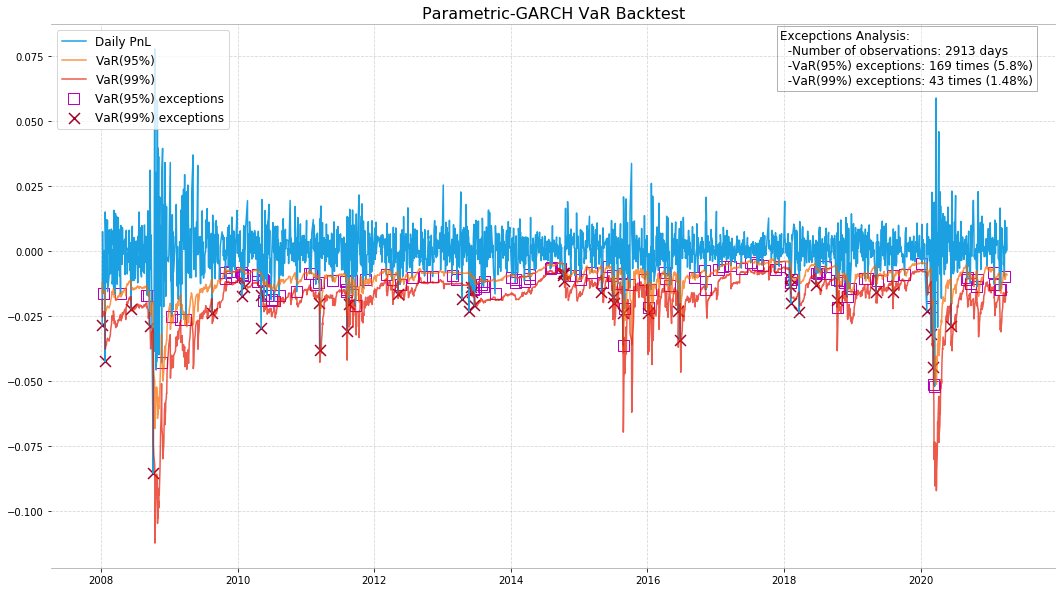

In [600]:
VaR.backtest_plot(garch_var, 'Parametric-GARCH', begin_date='2008-01-01', end_date='2021-06-01')

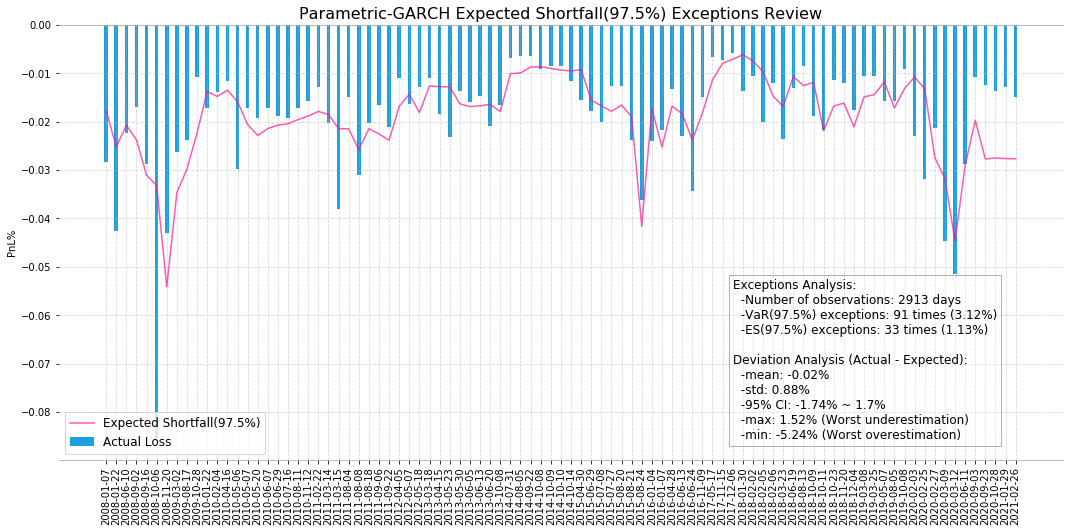

In [601]:
VaR.ES_plot(garch_var,'Parametric-GARCH',begin_date='2008-01-01')

#### *The plot methods allow users to set the start and the end dates of the backtest. The following graphs are backtest plots after 2020-01-01.

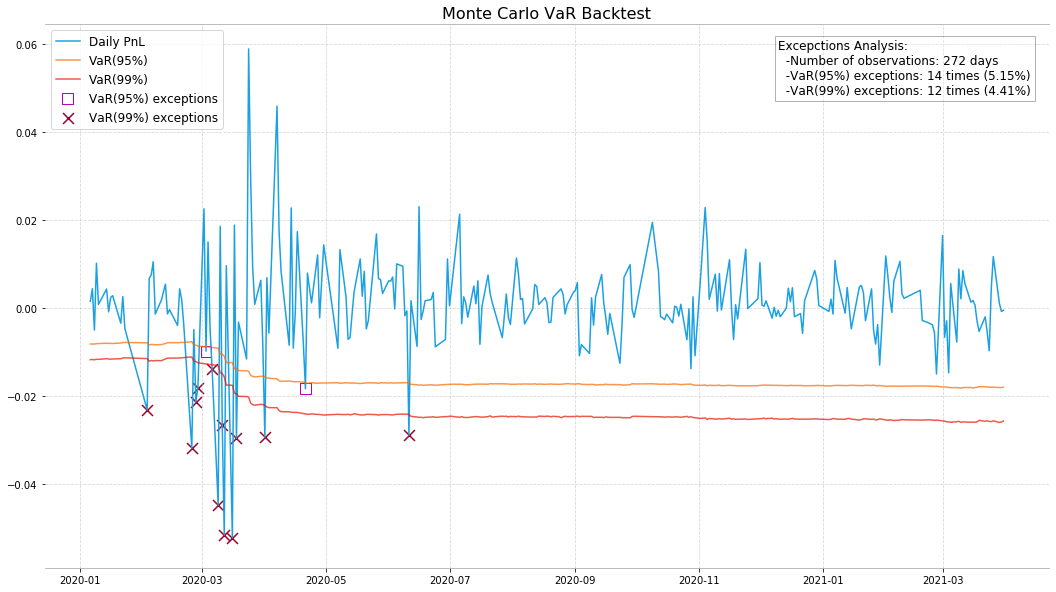

In [602]:
VaR.backtest_plot(mcvar, 'Monte Carlo', begin_date='2020-01-01', end_date='2021-03-31')

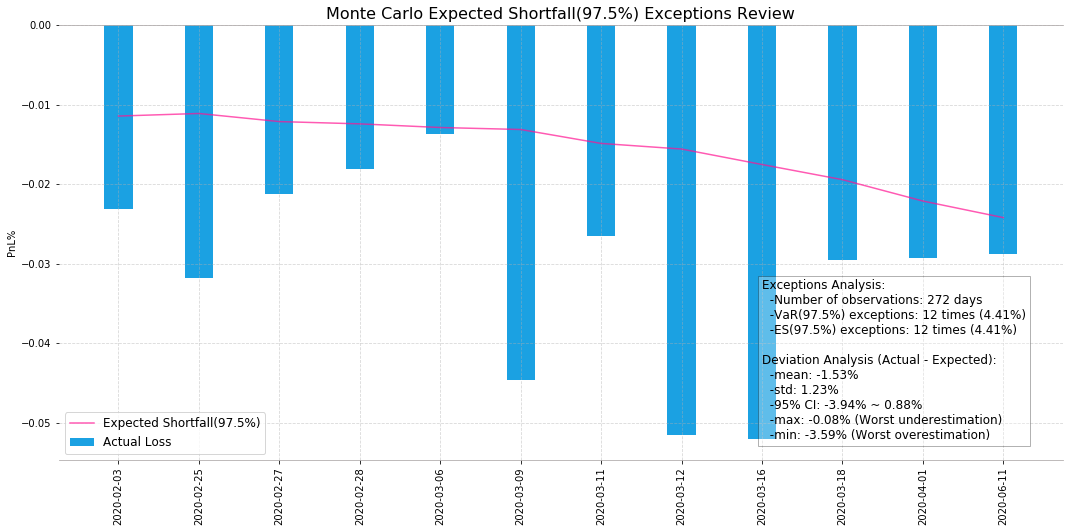

In [603]:
VaR.ES_plot(mcvar,'Monte Carlo',begin_date='2020-01-01', end_date='2021-03-31')